# Training

In [1]:
import torch
import scipy.io as sio
import glob
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.nn.utils import clip_grad_norm_
from neuralop.models import FNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop import LpLoss, H1Loss
from neuralop.utils import count_model_params
from neuralop.data.transforms.normalizers import UnitGaussianNormalizer
from abc import abstractmethod
import time
import seaborn as sns
import random
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

Training on device: cuda


In [2]:
# --- 1. Find and Load All Data Files ---
data_path = './FNO_Dataset_6_Channel_PT/'
file_paths = glob.glob(f"{data_path}/FNO_dataset_run_*.pt")
file_paths.sort()
random.shuffle(file_paths)

if not file_paths:
    raise FileNotFoundError(f"No .pt files found in {data_path}")

print(f"Found {len(file_paths)} data files.")

# --- 2. Split File Paths into Train and Test ---
train_fraction = 0.4
validation_fraction = 0.2

train_split = int(train_fraction * len(file_paths))
valid_split = int((train_fraction + validation_fraction) * len(file_paths))
train_paths = file_paths[:train_split]
valid_paths = file_paths[train_split:valid_split]
test_paths = file_paths[valid_split:]

with open('test_paths.txt', 'w') as f:
    for path in test_paths:
        f.write(path + '\n')

# --- 3. Load ALL Data into RAM for Normalization ---
# This is the workflow you prefer. It requires
# loading all training data into memory first.

def load_data_from_paths(paths): # <-- Removed data_key
    all_tensors = []
    for p in paths:
        try:
            # Load the .pt file directly as a tensor
            tensor_data = torch.load(p).float() # <-- Changed loading function
            all_tensors.append(tensor_data)
        except Exception as e:
            print(f"Warning: Error loading {p}: {e}")
    # Concatenate all runs along the time dimension (dim=0)
    return torch.cat(all_tensors, dim=0)

print("Loading training data into memory...")
train_data_sequence = load_data_from_paths(train_paths)
print(f"Full training sequence shape: {train_data_sequence.shape}")

print("Loading validation data into memory...")
validation_data_sequence = load_data_from_paths(valid_paths)
print(f"Full validation sequence shape: {validation_data_sequence.shape}")

print("Loading test data into memory...")
test_data_sequence = load_data_from_paths(test_paths)
print(f"Full test sequence shape: {test_data_sequence.shape}")

# --- 4. Fit and Transform (CORRECTED) ---

# --- A. Split the data ---
velocity_train_seq = train_data_sequence[:, 0:3, :, :, :]
velocity_valid_seq = validation_data_sequence[:, 0:3, :, :, :]
velocity_test_seq = test_data_sequence[:, 0:3, :, :, :]
# Excluding channels 4 and 5 as they are constant (gravity and rotational acceleration)
force_train_seq = train_data_sequence[:, 3, 0, 0, 0]
force_valid_seq = validation_data_sequence[:, 3, 0, 0, 0]
force_test_seq = test_data_sequence[:, 3, 0, 0, 0]

# --- B. Create TWO normalizers ---
velocity_normalizer = UnitGaussianNormalizer(dim=[0, 2, 3, 4]) 
force_normalizer = UnitGaussianNormalizer(dim=[0]) 

print("Fitting the normalizers.")
velocity_normalizer.fit(velocity_train_seq)
force_normalizer.fit(force_train_seq)

print("Normalizing the data.")
velocity_train_seq = velocity_normalizer.transform(velocity_train_seq)
velocity_valid_seq = velocity_normalizer.transform(velocity_valid_seq)
velocity_test_seq = velocity_normalizer.transform(velocity_test_seq)
force_train_seq = force_normalizer.transform(force_train_seq)
force_valid_seq = force_normalizer.transform(force_valid_seq)
force_test_seq = force_normalizer.transform(force_test_seq)
print("Normalization complete.")

spatial_dims = velocity_train_seq.shape[2:]
force_train_seq = force_train_seq.view(-1, 1, 1, 1, 1).expand(-1, -1, *spatial_dims)
force_valid_seq = force_valid_seq.view(-1, 1, 1, 1, 1).expand(-1, -1, *spatial_dims)
force_test_seq = force_test_seq.view(-1, 1, 1, 1, 1).expand(-1, -1, *spatial_dims)

train_data = torch.cat([velocity_train_seq, force_train_seq], dim=1)
valid_data = torch.cat([velocity_valid_seq, force_valid_seq], dim=1)
test_data = torch.cat([velocity_test_seq, force_test_seq], dim=1)

# --- FINAL SANITY CHECK ---
print(f"Normalized train data mean: {train_data.mean():.4f}") # Should be ~0.0
print(f"Normalized train data std: {train_data.std():.4f}")  # Should be ~1.0
print(f"Normalized validation data mean: {valid_data.mean():.4f}") # Should be ~0.0
print(f"Normalized validations data std: {valid_data.std():.4f}")  # Should be ~1.0
print(f"Normalized test data mean: {test_data.mean():.4f}") # Should be ~0.0
print(f"Normalized test data std: {test_data.std():.4f}")  # Should be ~1.0

print("Clearing RAM")
del train_data_sequence
del validation_data_sequence
del test_data_sequence
del velocity_train_seq
del velocity_valid_seq
del velocity_test_seq
del force_train_seq
del force_valid_seq
del force_test_seq

Found 1000 data files.
Loading training data into memory...
Full training sequence shape: torch.Size([16400, 6, 32, 32, 32])
Loading validation data into memory...
Full validation sequence shape: torch.Size([8200, 6, 32, 32, 32])
Loading test data into memory...
Full test sequence shape: torch.Size([16400, 6, 32, 32, 32])
Fitting the normalizers.
Normalizing the data.
Normalization complete.
Normalized train data mean: -0.0000
Normalized train data std: 1.0000
Normalized validation data mean: 0.0037
Normalized validations data std: 1.0458
Normalized test data mean: -0.0002
Normalized test data std: 1.0280
Clearing RAM


In [3]:
# --- 5. Define Simple Dataset Class ---
class TimeSteppingDataset(Dataset):
    """
    A simple dataset that just returns the (t, t+1) pairs
    from a pre-normalized data sequence.
    
    This version is "run-aware" to prevent mixing
    data from different simulation runs.
    """
    def __init__(self, data_sequence, steps_per_run):
        """
        Args:
            data_sequence (torch.Tensor): The giant tensor of all runs
            steps_per_run (int): The number of time steps in EACH run
                                 (e.g., 100)
        """
        self.data = data_sequence
        self.steps_per_run = steps_per_run
        
        # We can't use the last step of *any* run as an input 'x'
        self.valid_pairs_per_run = self.steps_per_run - 1
        
        # Calculate how many runs are in this tensor
        self.num_runs = self.data.shape[0] // self.steps_per_run
        
        if self.data.shape[0] % self.steps_per_run != 0:
            print(f"Warning: Data shape {self.data.shape[0]} is not "
                  f"perfectly divisible by steps_per_run {self.steps_per_run}")

    def __len__(self):
        """
        Returns the total number of *valid* (t, t+1) pairs.
        """
        return self.num_runs * self.valid_pairs_per_run

    def __getitem__(self, idx):
        """
        Gets the N-th *valid* pair, skipping boundaries.
        'idx' will be from 0 to (total_valid_pairs - 1)
        """
        
        # 1. Which run is this pair in?
        # e.g., if valid_pairs_per_run=99, idx=100 -> run_index=1
        run_index = idx // self.valid_pairs_per_run
        
        # 2. What is the time-index *within* that run?
        # e.g., if valid_pairs_per_run=99, idx=100 -> time_index=1
        time_index_in_run = idx % self.valid_pairs_per_run
        
        # 3. What is the *actual* index in the giant data tensor?
        # This calculation skips the boundary indices.
        # e.g., run_index=1, time_index=1 -> (1 * 100) + 1 = 101
        global_start_idx = (run_index * self.steps_per_run) + time_index_in_run
        
        # This will now correctly get (e.g.) data[101] and data[102]
        # and will *never* ask for (data[99], data[100])
        x = self.data[global_start_idx]
        y = self.data[global_start_idx + 1]
        
        return {'x': x, 'y': y[:3]}

In [4]:
# --- 6. Create Datasets and DataLoaders ---

# You must know this value from your data generation
# For example, if each .pt file had 100 time steps:
STEPS_PER_RUN = 41 

# Create the datasets from your NEW normalized tensors
train_dataset = TimeSteppingDataset(train_data, steps_per_run=STEPS_PER_RUN)
valid_dataset = TimeSteppingDataset(valid_data, steps_per_run=STEPS_PER_RUN)
test_dataset = TimeSteppingDataset(test_data, steps_per_run=STEPS_PER_RUN)

# Create the DataLoaders
# Try a small batch size first due to memory
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Manual Training

In [5]:
class GridMSELoss:
    def __init__(self, dim=[1, 2, 3, 4]):  # channel + spatial dims
        self.dim = dim

    def __call__(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        assert y_pred.shape == y_true.shape, f"Shape mismatch: {y_pred.shape} vs {y_true.shape}"
        return torch.mean((y_pred - y_true) ** 2, dim=self.dim).sum()

In [6]:
model = FNO(
    n_modes=(10, 10, 10),
    hidden_channels=64,
    in_channels=4,
    out_channels=3,
    n_layers=3
).to(device)

print(f"Model has {sum(p.numel() for p in model.parameters())} parameters.")

n_epochs = 50
# clip_value = 1.0
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

# Use MSE for training and evaluation
training_loss = GridMSELoss()
eval_loss = GridMSELoss()

Model has 7416035 parameters.


In [ ]:
# --- Setup for the loop ---
print("Starting manual training loop...")
best_valid_loss = float('inf')
save_dir = './checkpoints_mse_loss/'
os.makedirs(save_dir, exist_ok=True)

# --- Start Manual Training Loop ---
for epoch in range(n_epochs):
    epoch_start_time = time.time()
    
    # --- Training Phase ---
    model.train()
    total_train_loss = 0.0
    
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        out = model(batch['x'])
        loss = training_loss(out, batch['y'])
        loss.backward()
        # clip_grad_norm_(model.parameters(), max_norm=clip_value)
        optimizer.step()
        total_train_loss += loss.item()

    # --- Validation Phase ---
    model.eval()
    total_valid_loss = 0.0
    
    with torch.no_grad():
        for batch in valid_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(batch['x'])
            total_valid_loss += eval_loss(out, batch['y']).item()

    scheduler.step()
    
    # --- End of Epoch ---
    avg_train_loss = total_train_loss / len(train_loader)
    avg_valid_loss = total_valid_loss / len(valid_loader)
    epoch_time = time.time() - epoch_start_time

    print(f"[Epoch {epoch:04d}] time: {epoch_time:.2f}s, "
          f"Train Loss: {avg_train_loss:.6f}, "
          f"Valid MSE: {avg_valid_loss:.6f}")

    # --- Save Best Model ---
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        save_path = os.path.join(save_dir, 'best_model.pt')
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, save_path)
        print(f"  [Epoch {epoch:04d}] New best model saved. Valid MSE: {avg_valid_loss:.6f}")

print("Training complete.")

Starting manual training loop...
[Epoch 0000] time: 187.68s, Train Loss: 12.283709, Valid MSE: 9.262732
  [Epoch 0000] New best model saved. Valid MSE: 9.262732
[Epoch 0001] time: 188.65s, Train Loss: 7.446308, Valid MSE: 5.757017
  [Epoch 0001] New best model saved. Valid MSE: 5.757017
[Epoch 0002] time: 188.70s, Train Loss: 4.141513, Valid MSE: 4.002425
  [Epoch 0002] New best model saved. Valid MSE: 4.002425
[Epoch 0003] time: 187.64s, Train Loss: 3.260464, Valid MSE: 3.597092
  [Epoch 0003] New best model saved. Valid MSE: 3.597092
[Epoch 0004] time: 189.42s, Train Loss: 3.002624, Valid MSE: 3.360612
  [Epoch 0004] New best model saved. Valid MSE: 3.360612
[Epoch 0005] time: 187.99s, Train Loss: 2.757640, Valid MSE: 3.021943
  [Epoch 0005] New best model saved. Valid MSE: 3.021943
[Epoch 0006] time: 188.26s, Train Loss: 2.627780, Valid MSE: 2.880092
  [Epoch 0006] New best model saved. Valid MSE: 2.880092
[Epoch 0007] time: 188.20s, Train Loss: 2.426041, Valid MSE: 2.845244
  [Epoc

# Automated Training

In [28]:
# # --- 7. Define Model, Optimizer, Loss ---
# model = FNO(
#     n_modes=(8, 8, 8),
#     hidden_channels=4,
#     in_channels=4,
#     out_channels=3,
#     n_layers=2
# ).to(device) 

# print(f"Model has {count_model_params(model)} parameters.")

# n_epochs = 1000
# optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4) # Using the lower 1e-4 lr
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
# l2loss = LpLoss(d=3, p=2, reduction='mean')
# h1loss = H1Loss(d=3, reduction='mean')

# # --- 8. Create Trainer (No Processor) ---
# trainer = Trainer(model=model, n_epochs=n_epochs,
#                   device=device,
#                   wandb_log=False,
#                   eval_interval=1,
#                   use_distributed=False,
#                   verbose=True)

In [29]:
# # --- 9. Start Training ---
# print("Starting training on full, normalized dataset...")
# # Use the shape of one test sample as the key
# valid_key = valid_data[0].shape[1]
# trainer.train(train_loader=train_loader,
#               test_loaders={valid_key: valid_loader},
#               optimizer=optimizer,
#               scheduler=scheduler,
#               training_loss=l2loss,
#               eval_losses={'h1': h1loss, 'l2': l2loss},
#                 save_best=f'{valid_key}_l2',
#                 save_dir='./checkpoints_4_channels/')

# Testing

In [37]:
model_imp = FNO(
    n_modes=(10, 10, 10),
    hidden_channels=64,
    in_channels=4,
    out_channels=3,
    n_layers=3
).to(device)

checkpoint_path = './best_model.pt'
model_imp.load_state_dict(torch.load(checkpoint_path, weights_only=False))

<All keys matched successfully>

In [38]:
# Get one batch from the test loader
for batch in test_loader:
    x = batch['x'].to(device)         # Input tensor
    y = batch['y'].to(device)         # Target tensor
    break  # Only take the first batch

In [39]:
x_sample = x[20].unsqueeze(0)  # shape: [1, 4, X, Y, Z]
y_sample = y[20].unsqueeze(0)  # shape: [1, 3, X, Y, Z]

In [40]:
model_imp.eval()
with torch.no_grad():
    y_pred = model_imp(x_sample)

In [41]:
z_index = 5
true_slice = y_sample[0, :, :, :, z_index].cpu()
pred_slice = y_pred[0, :, :, :, z_index].cpu()
error_slice = torch.abs(true_slice - pred_slice)

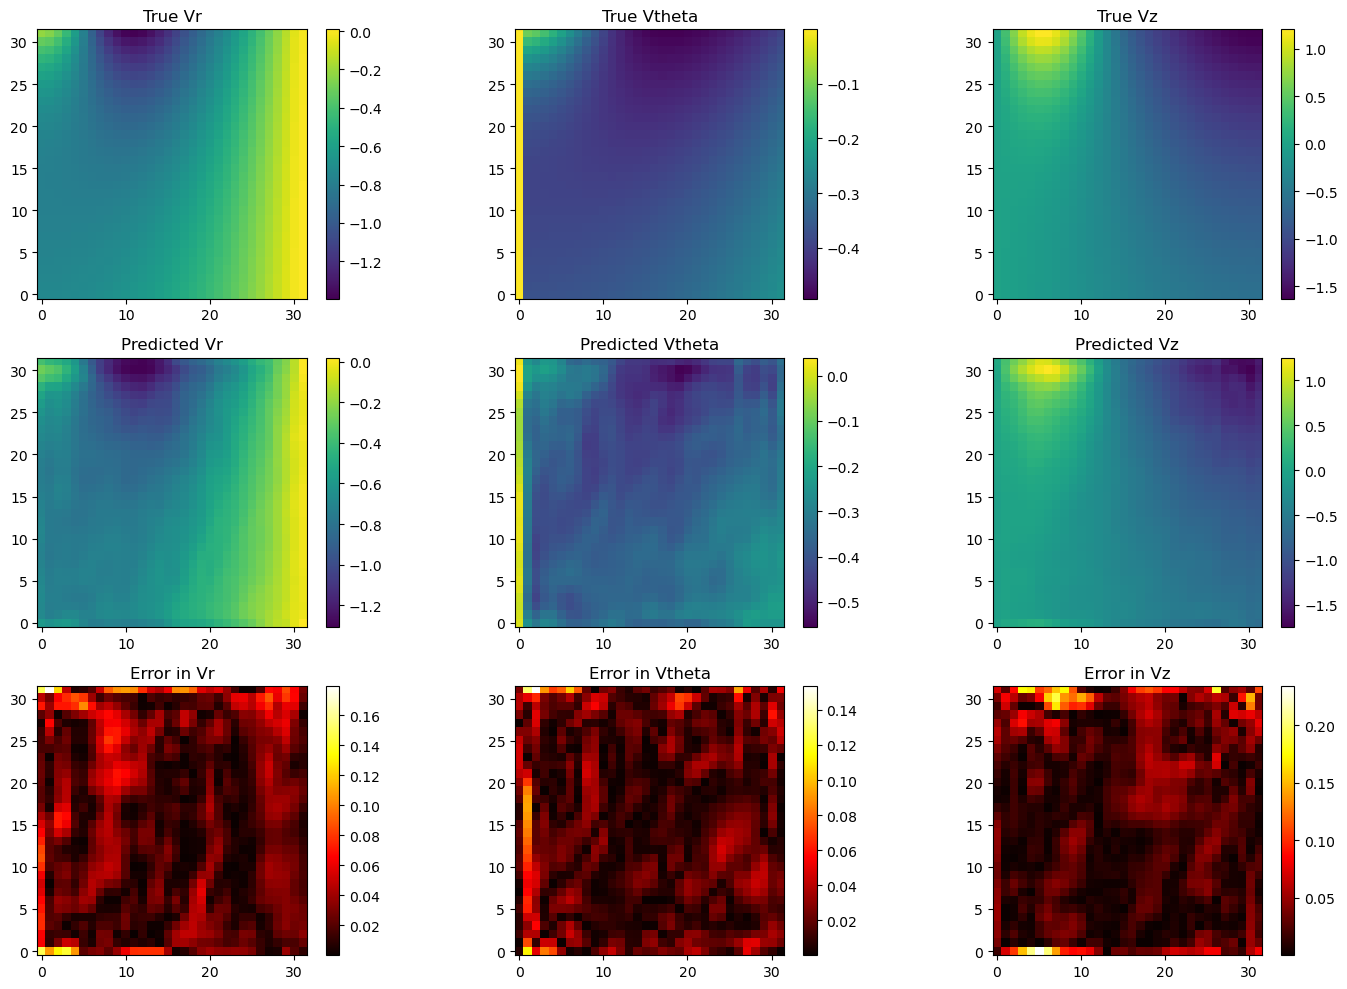

In [42]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
components = ['Vr', 'Vtheta', 'Vz']

for i in range(3):
    # True field
    im0 = axs[0, i].imshow(true_slice[i], cmap='viridis', origin='lower')
    axs[0, i].set_title(f"True {components[i]}")
    plt.colorbar(im0, ax=axs[0, i], fraction=0.046, pad=0.04)

    # Predicted field
    im1 = axs[1, i].imshow(pred_slice[i], cmap='viridis', origin='lower')
    axs[1, i].set_title(f"Predicted {components[i]}")
    plt.colorbar(im1, ax=axs[1, i], fraction=0.046, pad=0.04)

    # Error map
    im2 = axs[2, i].imshow(error_slice[i], cmap='hot', origin='lower')
    axs[2, i].set_title(f"Error in {components[i]}")
    plt.colorbar(im2, ax=axs[2, i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()